In [1]:
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
import os
import glob
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras.utils import to_categorical

/home/kadn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
parentpath = './hzw/'
pictype = 'png'

lufeifiles = glob.glob(os.path.join(parentpath+'lufei','*.'+pictype))
suolongfiles = glob.glob(os.path.join(parentpath+'suolong','*.'+pictype))
nameifiles = glob.glob(os.path.join(parentpath+'namei','*.'+pictype))
wusuopufiles = glob.glob(os.path.join(parentpath+'wusuopu','*.'+pictype))
qiaobafiles = glob.glob(os.path.join(parentpath+'qiaoba','*.'+pictype))
shanzhifiles = glob.glob(os.path.join(parentpath+'shanzhi','*.'+pictype))
luobinfiles = glob.glob(os.path.join(parentpath+'luobin','*.'+pictype))

totalfiles = [lufeifiles,suolongfiles,nameifiles,wusuopufiles,qiaobafiles,shanzhifiles,luobinfiles]

total =[[], [], [], [], [], [], []]
label = [[],[],[],[],[],[],[]]

def imgadd(img):
    h,w = img.shape[0],img.shape[1]
    if h == w:
        return img
    if h > w:
        e = h-w
        eimg = np.zeros([h,e,3])
        img = np.concatenate((img, eimg), axis=1)
        return img
    else:
        e = w-h
        eimg = np.zeros([e,w,3])
        img = np.concatenate((img, eimg), axis=0)
        return img


for i in range(len(total  )):
    for k in totalfiles[i]:
        img = cv2.imread(k)
        img = imgadd(img)
        img = cv2.resize(img, (128, 128), cv2.COLOR_RGB2BGR)
        total[i].append(img)
    total[i] = np.array(total[i], dtype='float32')
    total[i] = total[i] / 255.0
    label[i] = i*np.ones((total[i].shape[0],1))

for i in range(len(total)):
    print(total[i].shape)
    print(label[i].shape)

(117, 128, 128, 3)
(117, 1)
(90, 128, 128, 3)
(90, 1)
(84, 128, 128, 3)
(84, 1)
(77, 128, 128, 3)
(77, 1)
(102, 128, 128, 3)
(102, 1)
(47, 128, 128, 3)
(47, 1)
(105, 128, 128, 3)
(105, 1)


In [3]:
train_data = np.concatenate((total[0],
                            total[1],
                            total[2],
                            total[3],
                            total[4],
                            total[5],
                            total[6]),
                            axis=0)
print(train_data.shape)
train_label = np.concatenate(
                             (label[0],
                              label[1],
                              label[2],
                              label[3],
                              label[4],
                              label[5],
                              label[6]),
                              axis = 0)
train_label = to_categorical(train_label, num_classes=7)
print(train_label.shape)

(622, 128, 128, 3)
(622, 7)


In [4]:
# for i in range(20):
#     pyplot.imshow(train_data[i])
#     pyplot.show()


In [5]:
# print(train_data[0])

1.0
0.0


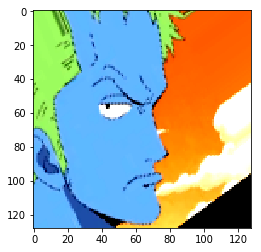

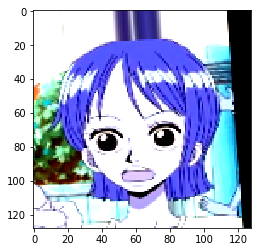

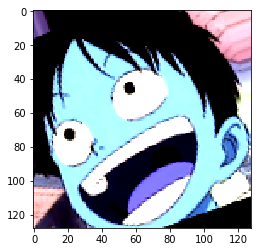

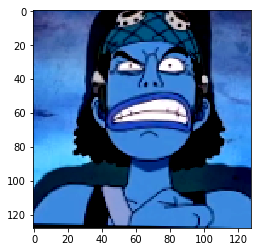

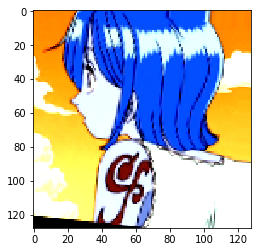

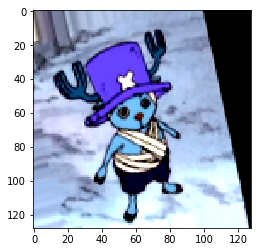

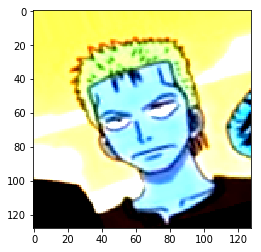

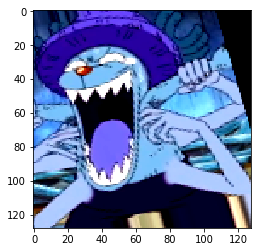

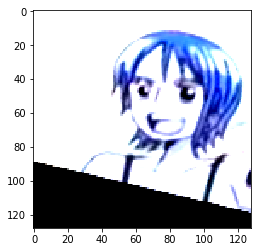

In [6]:


datagen = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.1, height_shift_range=0.1,
                            brightness_range=[0.8,1.5],
                            zoom_range=[0.8,1.2],
                            horizontal_flip=False,
                            vertical_flip=False,
                            rescale=1/128.0,
                            featurewise_center=True)
datagen.fit(train_data)

for batch_data, batch_label in datagen.flow(train_data, train_label, batch_size=9):
    batch_data = batch_data 
    batch_data = np.clip(batch_data, 0,1)
    print(batch_data.max())
    print(batch_data.min())
    for i in range(9):
        pyplot.imshow(batch_data[i])
        pyplot.show()
    break


In [7]:
from keras.models import Sequential  # 采用贯序模型
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
import numpy as np
import cv2

tBatchSize = 64
'''第一步：选择模型'''   #VGG16要求图片大小最少48 
model_vgg = VGG16(include_top=False, input_shape=(128,128,3))
for layer in model_vgg.layers:
    layer.trainable = False

model = Flatten(name='flatten')(model_vgg.output)
model = Dense(500, activation='relu', name='fc1')(model)
model = Dense(500, activation='relu', name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(7, activation='softmax')(model)
model = Model(inputs=model_vgg.input, 
                        outputs = model, name = 'vgg16')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 使用交叉熵作为loss函数


In [8]:
history = model.fit_generator(datagen.flow(train_data, train_label, 
                                           batch_size=32), 
                              steps_per_epoch = 1000,
                              epochs = 3)

Epoch 1/3
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0939 - acc: 0.9687
Epoch 2/3
1000/1000 [==============================] - 116s 116ms/step - loss: 0.0257 - acc: 0.9925
Epoch 3/3
1000/1000 [==============================] - 115s 115ms/step - loss: 0.0151 - acc: 0.9957


In [7]:
# model.save('./model/hzw.h5')

In [ ]:
# from keras.models import load_model
# model = load_model('./model/hzw.h5')

In [10]:
train_data = (train_data - train_data.mean()) / train_data.std()
scores,acc = model.evaluate(train_data,train_label, batch_size=tBatchSize, verbose=0)
print(scores, acc)

1.1825827681066912e-05 1.0


batch max :  1.4749496
batch_min :  -0.61437005


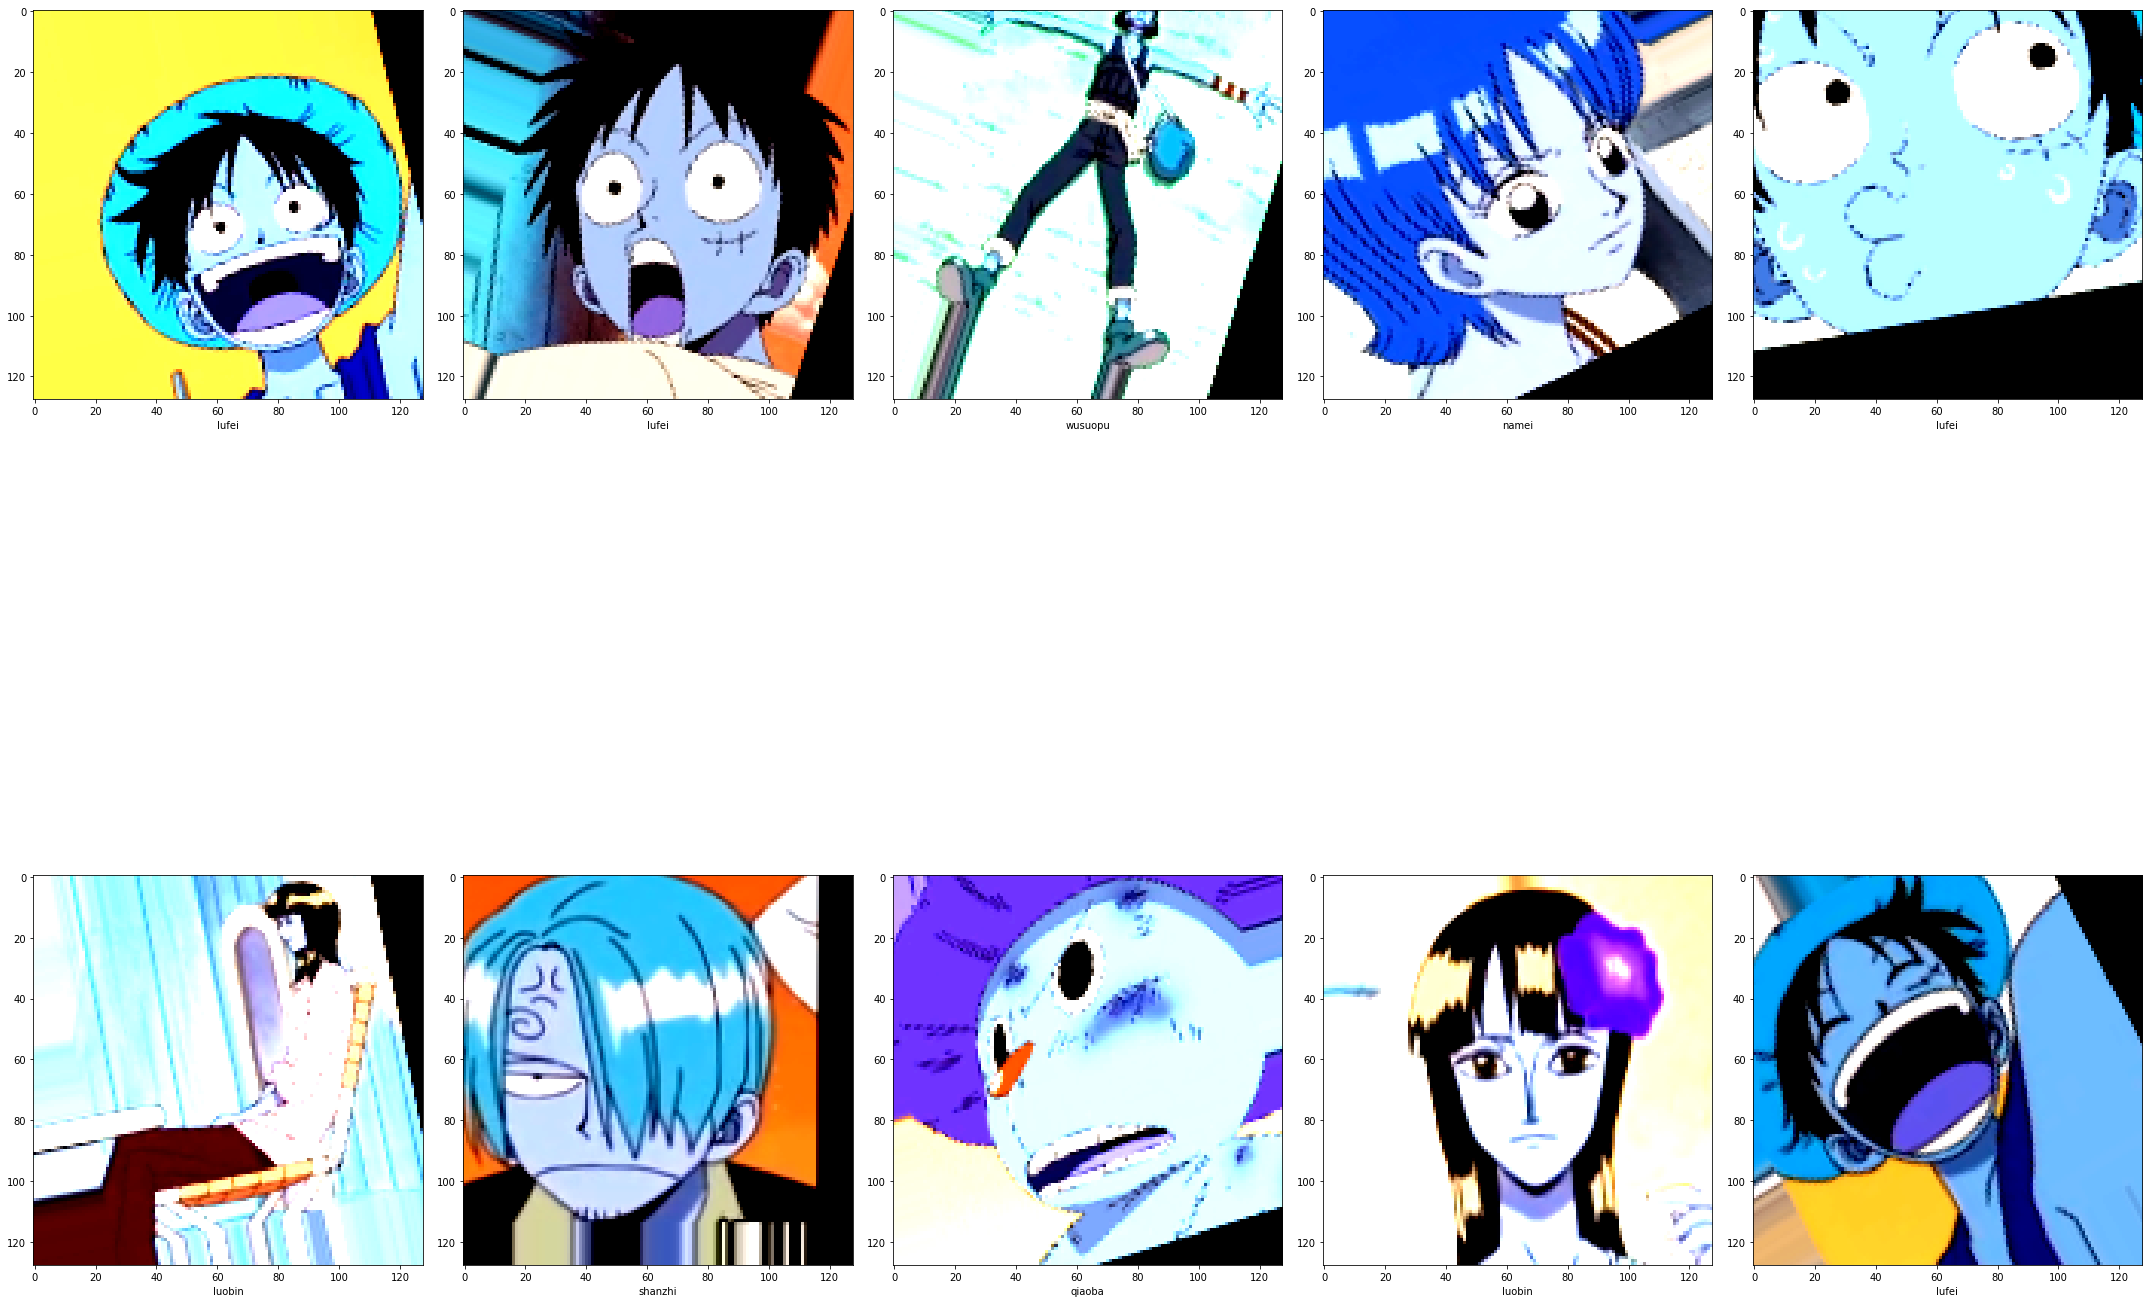

[0 0 3 2 0 6 5 4 6 0]


In [47]:
res = []
d = {0:'路飞', 1:'索隆', 2:'娜美', 3:'乌索普', 4:'乔巴', 5:'山治', 6:'罗宾'}
d = {0:'lufei', 1:'suolong', 2:'namei', 3:'wusuopu', 4:'qiaoba', 5:'shanzhi', 6:'luobin'}
import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname="Light.ttc")
for batch_data, batch_label in datagen.flow(train_data, train_label, batch_size=10):
    res = model.predict(batch_data)
    print('batch max : ',batch_data.max())
    print('batch_min : ',batch_data.min())
    batch_data = np.clip(batch_data, 0,1)
    
    for i in range(10):
        ax = pyplot.subplot(2,5,i+1)
        pyplot.imshow(batch_data[i])
        ax.set_xlabel('{}'.format(d[np.argmax(res[i])]))
#     pyplot.axis('on')
    pyplot.tight_layout()
    pyplot.rcParams['figure.figsize'] = (25.0, 25.0)
    pyplot.show()
    break
print( np.argmax(res, axis=1))

In [12]:
testpic = cv2.imread('./hzw2/wusuopu/0021.jpg')
testpic = cv2.resize(testpic,(128,128))
# for i in range(3):
#     testpic[:,:,i] = (testpic[:,:,i]-np.mean(testpic[:,:,i]))/np.std(testpic[:,:,i])
print(testpic.max())
print(testpic.min())
testpic = (testpic - np.mean(testpic)) / np.std(testpic)
testpic = testpic.reshape(1,128,128,3)
result = model.predict(testpic)
print(result)

255
0
[[1.7845086e-12 1.0506850e-15 2.1688066e-16 1.0000000e+00 1.1528737e-15
  5.9468263e-19 2.0061175e-15]]
